In [1]:
import pandas as pd
import numpy as np
import sys

version = ".".join(map(str, sys.version_info[:3]))
print('python version ', version)
print('numpy version ', np.__version__)
print('pandas version ',pd.__version__)

python version  3.6.2
numpy version  1.13.1
pandas version  0.20.3


In [2]:
import geopandas as gpd
import pysal

print("geopandas version ", gpd.__version__)

geopandas version  0.2.1


In [3]:
import matplotlib.pyplot as plt

In [4]:
# Tell the kernel that we want the plots to be in this notebook
# and not in an external window
%matplotlib inline

### County Business Patterns 2015
The County Business Patterns data provides the number of people employed by job type as well as payroll data.  There is noise added to the data to prevent people from being able to identify data for a particular company.  We want to determine the number of people employed in ecommerce ( US Labor department NAICS 454111 )

In [5]:
filename = '../../data/census/CBP/cbp15co.txt'
cbp_county_2015_df = pd.read_csv(filename,
                                 dtype={'FIPSTATE': str,
                                        'FIPSCTY': str})
print('rows, columns ', cbp_county_2015_df.shape)
cbp_county_2015_df.head()

rows, columns  (2126601, 26)


,FIPSTATE,FIPSCTY,NAICS,EMPFLAG,EMP_NF,EMP,QP1_NF,QP1,AP_NF,AP,...,N100_249,N250_499,N500_999,N1000,N1000_1,N1000_2,N1000_3,N1000_4,CENSTATE,CENCTY
0,01,001,------,NaN,G,10454,G,76437,G,321433,...,6,2,1,0,0,0,0,0,63,1
1,01,001,11----,NaN,H,70,H,790,H,3566,...,0,0,0,0,0,0,0,0,63,1
2,01,001,113///,NaN,H,70,H,790,H,3551,...,0,0,0,0,0,0,0,0,63,1
3,01,001,1133//,NaN,H,70,H,790,H,3551,...,0,0,0,0,0,0,0,0,63,1
4,01,001,11331/,NaN,H,70,H,790,H,3551,...,0,0,0,0,0,0,0,0,63,1


In [6]:
geoids = [state + county for state, county in zip(cbp_county_2015_df['FIPSTATE'], cbp_county_2015_df['FIPSCTY'])]
cbp_county_2015_df['GEOID'] = geoids

In [7]:
ecom_df = cbp_county_2015_df[cbp_county_2015_df['NAICS'] == '454111']
ecom_df.shape

(1824, 27)

In [8]:
ecom_co_gt39_df = ecom_df[ecom_df.EMP > 39]
ecom_co_gt39_df.shape

(441, 27)

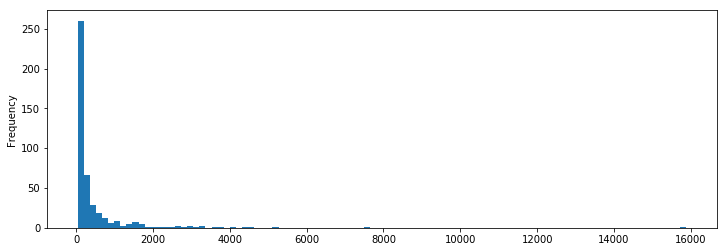

In [9]:
ecom_co_gt39_df['EMP'].plot.hist(bins=100, figsize=(12,4))

### US County shapefile
We want the county FIPS unique identifier as well as the centroid in order to plot points that represent ecommerce employees.  We do not need to plot polygons for the actual counties.

In [10]:
cb_2015_us_county = '../../data/shapefiles/cb_2015_us_county_20m/cb_2015_us_county_20m.shp'
us_county_df = gpd.read_file(cb_2015_us_county)
us_county_df.head(3)

,AFFGEOID,ALAND,AWATER,COUNTYFP,COUNTYNS,GEOID,LSAD,NAME,STATEFP,geometry
0,0500000US20175,1655865960,2777350,175,00485050,20175,06,Seward,20,"POLYGON ((-101.067904 37.38777899999999, -100...."
1,0500000US28141,1098939230,52359814,141,00695791,28141,06,Tishomingo,28,"POLYGON ((-88.36353026853919 34.9957467517971,..."
2,0500000US36101,3601566799,34993606,101,00974148,36101,06,Steuben,36,"POLYGON ((-77.72296399999999 42.471216, -77.72..."


In [43]:
county_centers = us_county_df['geometry'].centroid

In [44]:
county_centers_df = pd.DataFrame({'GEOID': us_county_df['GEOID'],
                                  'NAME': us_county_df['NAME'],
                                  'geometry': county_centers})

In [45]:
print('county_centers_df rows, cols', county_centers_df.shape)
county_centers_df.head(3)

county_centers_df rows, cols (3220, 3)


,GEOID,NAME,geometry
0,20175,Seward,POINT (-100.8507203935776 37.1932460366464)
1,28141,Tishomingo,POINT (-88.23917218699026 34.74023475345153)
2,36101,Steuben,POINT (-77.38210917713363 42.26885816344652)


### US State shapefile
We want the US states shapefile to be the bottom layer to help give the view geographic context.  Additional geographic context is given through city names and points.

In [11]:
cb_2015_us_state = '../../data/shapefiles/cb_2015_us_state_20m/cb_2015_us_state_20m.shp'
us_state_df = gpd.read_file(cb_2015_us_state)
us_state_df.head(3)

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
0,0400000US48,676634395761,19027462392,48,00,Texas,48,01779801,TX,"POLYGON ((-106.623445 31.914034, -106.630114 3..."
1,0400000US06,403488955894,20477992907,06,00,California,06,01779778,CA,"(POLYGON ((-118.593969 33.467198, -118.484785 ..."
2,0400000US21,102266253024,2389483091,21,00,Kentucky,21,01779786,KY,"POLYGON ((-89.544434 36.57451, -89.47934599999..."


### Core Based Statistical Areas shapefile
Two subsets/categories of these statistical areas will be plotted in order to highlight the fact that more people are employed with the ecommerce NAICS in urban areas.

In [12]:
cb_2015_us_cbsa = '../../data/shapefiles/cb_2015_us_cbsa_20m/cb_2015_us_cbsa_20m.shp'
us_cbsa_df = gpd.read_file(cb_2015_us_cbsa)
us_cbsa_df.head(3)

,AFFGEOID,ALAND,AWATER,CBSAFP,CSAFP,GEOID,LSAD,NAME,geometry
0,310M200US12660,2152007753,45296336,12660,357,12660,M2,"Baraboo, WI","POLYGON ((-90.312404 43.640988, -89.785809 43...."
1,310M200US10420,2331619578,62018442,10420,184,10420,M1,"Akron, OH","POLYGON ((-81.68698999999999 41.135956, -81.68..."
2,310M200US26540,991056505,13133894,26540,258,26540,M2,"Huntington, IN","POLYGON ((-85.64384099999999 41.002305, -85.33..."


### List of cities and their location


In [13]:
cities_df = pd.read_csv('../../data/cities.csv')
cities_df.head(3)

,city_name,long,lat,nx,ny
0,Seattle,-122.3321,47.60621,-1.5,0.0
1,Portland,-122.6765,45.52306,-1.5,0.0
2,Boise,-116.2146,43.61871,1.2,-0.5


In [47]:
from shapely.geometry import Point
points = gpd.GeoSeries([Point(lon,lat) for lon,lat in zip(cities_df.long, cities_df.lat)])

In [49]:
cities_df['geometry'] = points
cities_df.head(3)

,city_name,long,lat,nx,ny,xy,geometry
0,Seattle,-122.3321,47.60621,-1.5,0.0,"(-122.3321, 47.60621)",POINT (-122.3321 47.60621)
1,Portland,-122.6765,45.52306,-1.5,0.0,"(-122.6765, 45.52306)",POINT (-122.6765 45.52306)
2,Boise,-116.2146,43.61871,1.2,-0.5,"(-116.2146, 43.61871)",POINT (-116.2146 43.61871)


### The column names long, lat, nx, ny are prepended with a space character

In [14]:
cities_df.columns

Index(['city_name', ' long', ' lat', ' nx', ' ny'], dtype='object')

In [15]:
cities_df.columns = ['city_name', 'long', 'lat', 'nx', 'ny']
xy = [(x,y) for x,y in zip(cities_df['long'], cities_df['lat'])]
cities_df['xy'] = xy
cities_df.head(3)

,city_name,long,lat,nx,ny,xy
0,Seattle,-122.3321,47.60621,-1.5,0.0,"(-122.3321, 47.60621)"
1,Portland,-122.6765,45.52306,-1.5,0.0,"(-122.6765, 45.52306)"
2,Boise,-116.2146,43.61871,1.2,-0.5,"(-116.2146, 43.61871)"


### Population estimates by CBSA
We want to use these population estimates to select polygons for metropolitan areas with more than 1M people as well as metropolitan areas with populations between 250k and 1M

In [41]:
pop_cbsa_2015_df = pd.read_csv('../../data/census/cbsa-est2016-alldata-alt.csv',
                               encoding='latin-1',
                               usecols=['CBSA','NAME','POPESTIMATE2015','RESIDUAL2015'],
                               dtype={'CBSA':str,
                                      'NAME':str,
                                      'POPESTIMATE2015':object,
                                      'RESIDUAL2015':object})
print('pop_cbsa_2015_df rows,cols ', pop_cbsa_2015_df.shape)
pop_cbsa_2015_df.head(3)

pop_cbsa_2015_df rows,cols  (2792, 4)


,CBSA,NAME,POPESTIMATE2015,RESIDUAL2015
0,10180,"Abilene, TX",169893,-13
1,10180,"Callahan County, TX",13596,-9
2,10180,"Jones County, TX",19972,-20


In [16]:
fips_states_outside = set(['02','15','72','66',
                       '78','60','69','64',
                       '68','70','74',
                       '81', '84', '86', '87',
                       '89', '71', '76', '95',
                       '79'])

In [17]:
us_cstate_df = us_state_df[np.logical_not(us_state_df['GEOID'].isin(fips_states_outside))]

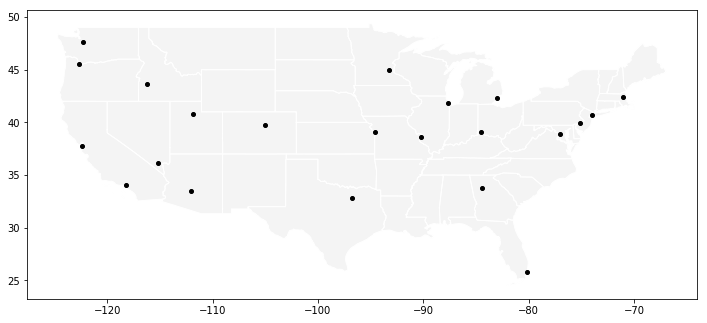

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (12,10))
ax.set_aspect('equal')
us_cstate_df.plot(ax=ax,
                  linewidth = 1,
                  facecolor="#EBEBEB",
                  edgecolor="white")
points.geometry.plot(ax=ax,
               marker='o',
               color='black',
               markersize=4)